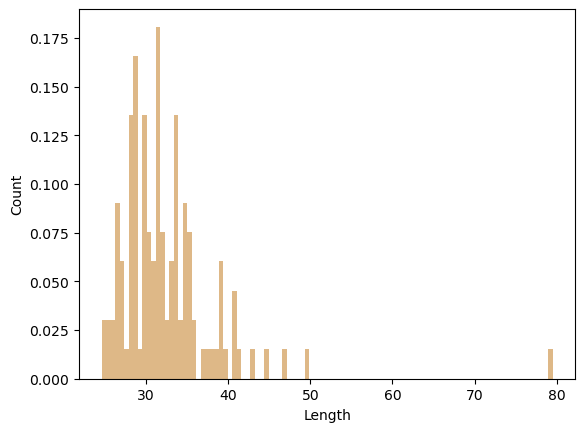

20.458168029785156 43.04212188720703


tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,      117 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        0 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        5 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]        5 read,        5 written


In [37]:
import nibabel as nib
from dipy.io.streamline import load_tractogram, save_trk
from dipy.tracking.utils import length
import numpy as np
import subprocess
import os

tract_path = "../study/subjects/VNSLC_19/dMRI/tractography/right-thalamus-Insula.tck"
# remotion of outliers IQR rule
trk = nib.streamlines.load(tract_path).tractogram
bundle  = trk.streamlines

lengths = list(length(bundle))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood', bins=100, density=True)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()

q1 = np.quantile(lengths, 0.25)
q3 = np.quantile(lengths, 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
print(lower, upper)

cmd = "tckedit -minlength %f -maxlength %f -force %s %s" % (lower, upper,tract_path, "../prova.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()

cmd = "tckedit -maxlength %f -force %s %s" % (lower,tract_path, "../lower.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()

cmd = "tckedit -minlength %f -force %s %s" % (upper, tract_path, "../upper.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()

cmd = "tckedit -force %s %s %s" % ("../lower.tck", "../upper.tck", "../removed.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()
os.remove("../lower.tck"); os.remove("../upper.tck")

tract = load_tractogram("../prova.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../prova.trk")

tract = load_tractogram("../removed.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../removed.trk")